In [ ]:
# Mateusz Biegański
# mb385162

# Data Mining 2020-2021 course, MIMUW

In [109]:
# Libraries used.

# Frequent itemsets + association rules
library(arules);

# Python-like fstrings.
library(glue);

# Misc utils.
library(dplyr);

# Plots.
library(ggplot2);

# B-splines for 'ggplot' smooth plots. 
library(splines);

# Reading .csv in efficient way.
library(data.table);


In [110]:
# Helper functions.

m  = function(x) print(methods(class=class(x)))
p  = function(x) print(glue(x))
ph = function(x) print(head(x))
pt = function(x) print(tail(x))
pc = function(x) print(class(x))


In [119]:
# IMPORTANT - disk size of whole data file is about 5.4GB, and after reading it into RAM
# R process uses about 6.4GB of memory.

# For computation time I decided to shuffle dataset and take 1M of records 
# (about 1/50 of dataset - full data is about 54M records).

# To convert data quickly (about 40s to shuffle, optionally take only winning ones and take first 1M)
# I created bash script "convert_csv.sh" that I append to my solution.
# It uses standard UNIX tools like grep, head, sed, shuf.
# To generate DATA_FNAME run command './convert_csv.sh --basic'
# To generate WINNING_DATA_FNAME run command './convert_csv.sh --basic --winning'

# Or, you can download it via
# $ wget https://students.mimuw.edu.pl/~mb385162/data-mining.zip -O data-mining.zip

DATA_FNAME = "shuffled1M.csv"
WINNING_DATA_FNAME = "shuffled_winning1M.csv"
data = fread(DATA_FNAME)


Warning message in fread(DATA_FNAME):
“Detected 3 column names but the data has 9 columns (i.e. invalid file). Added 6 extra default column names at the end.”


In [120]:
# Sort games by timestamp.
data = data[order(data$timestamp, decreasing=FALSE)]
data_len = length(data$timestamp)
data_begin_day = format(data$timestamp[[1]], '%d-%m-%Y')
data_end_day = format(data$timestamp[[data_len]], '%d-%m-%Y')

p("Our dataset contains results of {data_len} games played from {data_begin_day} up to {data_end_day}.")


Our dataset contains results of 999999 games played from 31-12-2018 up to 31-01-2019.


In [114]:
# Read transactions.
transactions = arules::read.transactions(DATA_FNAME, format="basket", head=1, sep=',', cols=1)

In [121]:
# For each game we introduce two transactions - one for each players (single transaction contains set of cards from one player's deck).
inspect(head(transactions, n=1))
inspect(tail(transactions, n=1))

    items                  transactionID
[1] {barbarian-hut,                     
     dart-goblin,                       
     goblin-hut,                        
     minions,                           
     princess,                          
     the-log,                           
     valkyrie,                          
     x-bow}         2019-01-05T00:29:59Z
    items                     transactionID
[1] {elite-barbarians,                     
     fire-spirits,                         
     inferno-tower,                        
     miner,                                
     prince,                               
     skeleton-army,                        
     the-log,                              
     zap}              2019-01-04T08:45:14Z


In [122]:
minSupport = 0.01

# Generate frequent itemsets (using arules::Apriori implementation). 
frequentItemSets = apriori(transactions, 
                           parameter = list(supp = minSupport, 
                                            minlen = 1, 
                                            target = "frequent itemsets"),
                           appearance = NULL, control = list(verbose = FALSE))

In [123]:
# n_sets(x) returns list of frequent itemsets of size 'x', sorted decreasing by support value.
n_sets = function(frequent_itemsets, n) arules::sort(frequent_itemsets[which(size(frequent_itemsets) == n)], decreasing=TRUE)


In [124]:
# Look for single most-popular cards (Overall time).
a = n_sets(frequentItemSets, 1)
inspect(head(a))
l = labels(a[1])
s = support(a[1], transactions)
p("Here is the list of most popular cards (overall). The most popular card, the {l} was used in {100 * s}% of all decks!")


    items         support   transIdenticalToItemsets count 
[1] {zap}         0.4328844 0                        432884
[2] {fireball}    0.3339913 0                        333991
[3] {wizard}      0.2866393 0                        286639
[4] {the-log}     0.2803573 0                        280357
[5] {hog-rider}   0.2690483 0                        269048
[6] {goblin-gang} 0.2599583 0                        259958
Here is the list of most popular cards (overall). The most popular card, the {zap} was used in 43.2884432884433% of all decks!


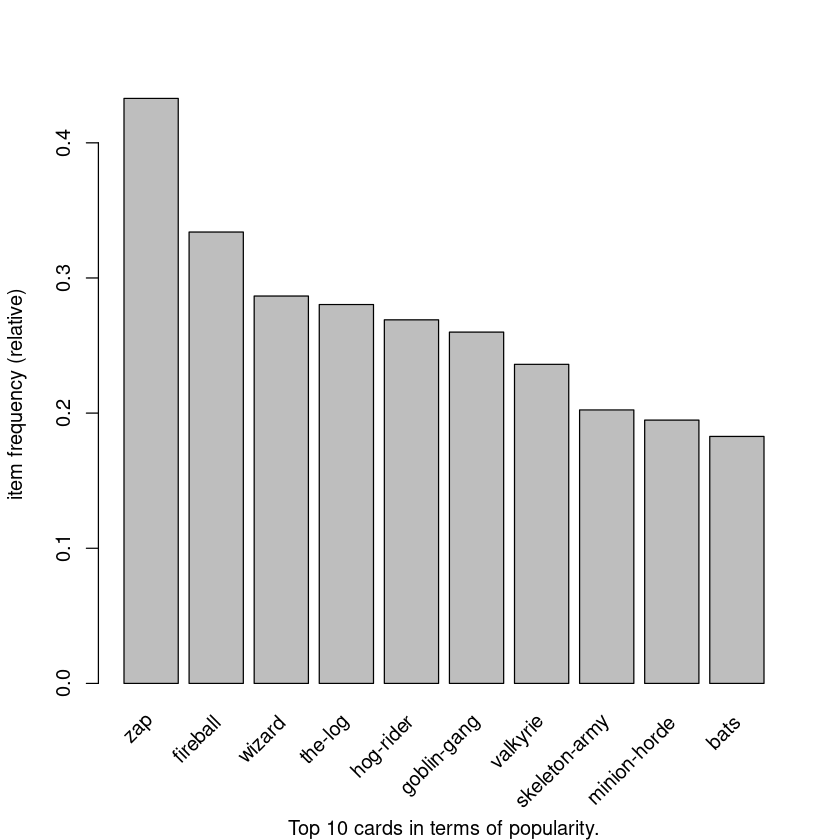

In [128]:
itemFrequencyPlot(transactions, topN=10, xlab="Top 10 cards in terms of popularity.")

In [134]:
# What about card popularity in time?
# Calculate daily frequent itemsets to gain ability of comparing support in time series.

df = as.Date(transactionInfo(transactions)$transactionID, format="%Y-%m-%dT%H:%M:%S")
split_groups = df - min(df)
s = split(transactions, split_groups)

x_axis = lapply(s, function(x) transactionInfo(x)[[1]][[1]])
x_axis = lapply(x_axis, as.Date, format="%Y-%m-%dT%H:%M:%S")

res = data.frame()
popular_cards = c()
for (v in 1:length(s)) {
    f = apriori(s[[v]], 
                parameter = list(supp = minSupport, 
                                minlen = 1, 
                                maxlen = 1,
                                target = "frequent itemsets"),
                appearance = NULL, control = list(verbose = FALSE))
    f = DATAFRAME(n_sets(f, 1))
    f$chunk = v
    f$chunk_start_date = x_axis[[v]]
    popular_cards = c(popular_cards, as.character(f$items[1:4]))
    res = rbind(res, f)
}
popular_cards = as(popular_cards, "matrix")
popular_in_time = dplyr::filter(res, items %in% popular_cards)


Popularity of 5 most frequently used cards in time.
[1] "As we see, the Wizard card's usage trend is growing, while anothers' top cards trends going down."


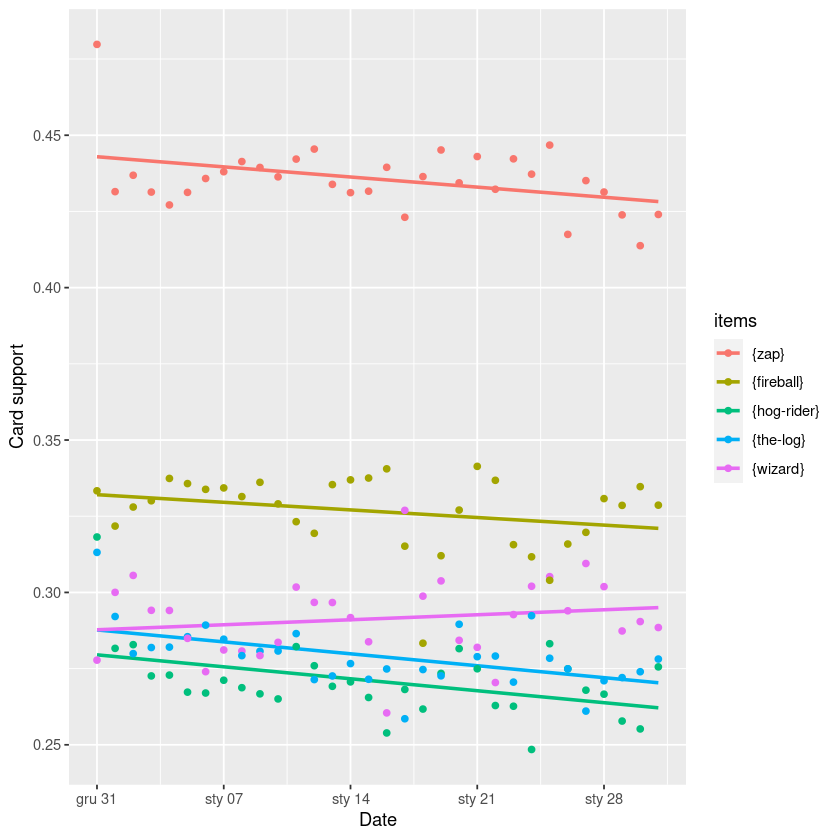

In [136]:
p("Popularity of {length(unique(popular_cards))} most frequently used cards in time.")
gg = ggplot(popular_in_time, aes(x=chunk_start_date, y=support, colour=items))
gg = gg + stat_smooth(
    aes(x = chunk_start_date, y = support, colour=items), 
    method = "lm", 
    se=FALSE, 
    fullrange=TRUE, 
    formula = y ~ x, # ns(x, 30)
) 
gg = gg + geom_point()
gg = gg + xlab("Date") + ylab("Card support")
# gg = gg + theme(legend.position = "none")
plot(gg)
print("As we see, the Wizard card's usage trend is growing, while anothers' top cards trends going down.")

In [137]:
# Association rules might be helpful for recommendation engine.

rules = ruleInduction(frequentItemSets, transactions, confidence = 0.6, 
                           control = list(method = "apriori", verbose = FALSE))

# inspect(head(rules))

lhs_rules = function(lhs) {
    res = dplyr::filter(DATAFRAME(rules), grepl(lhs, as.character(LHS)))
    res = res[order(res$support, decreasing=TRUE),]
    res
}
cannon_rules = lhs_rules("cannon")
head(cannon_rules)


,LHS,RHS,support,confidence,coverage,lift,count
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,{cannon},{hog-rider},0.01865502,0.7058000,0.02643103,2.623321,18655
2,{cannon},{fireball},0.01844302,0.6977791,0.02643103,2.089213,18443
39,"{cannon,hog-rider}",{fireball},0.01530002,0.8201555,0.01865502,2.455619,15300
40,"{cannon,fireball}",{hog-rider},0.01530002,0.8295830,0.01844302,3.083399,15300
31,"{cannon,musketeer}",{hog-rider},0.01359001,0.8989284,0.01511802,3.341142,13590
32,"{cannon,hog-rider}",{musketeer},0.01359001,0.7284910,0.01865502,7.108193,13590


We managed to find most popular cards and set of cards, and to investigate it's popularity in time.
We have mined some association rules, which is first step to create our recommendation system.
However, for now **we haven't took games results (win or lose) into consideration**. Now it's time to take deck winning ratio into account.

In [138]:
# shuffled data, only has_win=1 taken.
winning = fread(WINNING_DATA_FNAME)

head(winning)

Warning message in fread(WINNING_DATA_FNAME):
“Detected 3 column names but the data has 9 columns (i.e. invalid file). Added 6 extra default column names at the end.”


timestamp,player,deck,V4,V5,V6,V7,V8,V9
<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2019-01-29 23:30:09,baby-dragon,bandit,mini-pekka,pekka,rage,rocket,valkyrie,wizard
2019-01-07 02:21:04,executioner,fireball,hog-rider,ice-spirit,minions,mini-pekka,the-log,tornado
2019-01-03 23:59:49,archers,dart-goblin,freeze,hog-rider,mega-knight,tesla,wizard,zap
2019-01-07 02:18:27,archers,fireball,fire-spirits,goblin-barrel,hog-rider,inferno-tower,skeleton-army,zap
2019-01-08 00:55:56,archers,elite-barbarians,heal,ice-wizard,knight,minion-horde,prince,zap
2019-01-14 04:42:21,freeze,graveyard,guards,pekka,poison,tesla,wizard,zap


In [140]:
# Generate frequent itemsets (this time only for winning decks). 
minSupport = 0.01

winningTransactions = arules::read.transactions(WINNING_DATA_FNAME, format="basket", head=1, sep=',', cols=1)

frequentWinningItemSets = apriori(winningTransactions, 
                           parameter = list(supp = minSupport, 
                                            minlen = 1, 
                                            target = "frequent itemsets"),
                           appearance = NULL, control = list(verbose = FALSE))


In [141]:
# Now, let's investigate support of both average and winning sets.
size = c(1,2,3,4)
SUPP = lapply(size, function(x) head(n_sets(frequentItemSets, x)))
WINNING_SUPP = lapply(size, function(x) head(n_sets(frequentWinningItemSets, x)))
                      
for (i in 1:length(size)) {
    print("=================== AVERAGE VS WINNING =====================================================")
    print("============================================================================================")
    inspect(SUPP[[i]])
    inspect(WINNING_SUPP[[i]])
}


[1] "=================== AVERAGE VS WINNING ====================================================="
[1] "============================================================================================"
    items         support   transIdenticalToItemsets count 
[1] {zap}         0.4328844 0                        432884
[2] {fireball}    0.3339913 0                        333991
[3] {wizard}      0.2866393 0                        286639
[4] {the-log}     0.2803573 0                        280357
[5] {hog-rider}   0.2690483 0                        269048
[6] {goblin-gang} 0.2599583 0                        259958
    items         support   transIdenticalToItemsets count 
[1] {zap}         0.4393064 0                        439306
[2] {fireball}    0.3374183 0                        337418
[3] {the-log}     0.2830283 0                        283028
[4] {wizard}      0.2802543 0                        280254
[5] {hog-rider}   0.2723163 0                        272316
[6] {goblin-gang} 0.26

Very interesting observation we have done - **frequent sets of winning games contain almost the same cards as frequent sets of all games (of which 50% is lost)**. Main visible difference is, that winning sets' support of most popular cards is higher, and increases with size of set (roghly about 5% higher than for average decks for 4-sets). 

### Recommendation engine

To build recommendation engine, we will use SVD decomposition, calculate concepts and suggest cards that were frequently used by another players with deck, that contained chosen profile (as profile we consider set of 4 chosen cards). To increase probability of recommending good cards, we will create our SVD decomposition based on **only winning decks**.

('highly' inspired by "DM_lab4_recommender_systems.Rmd")

In [142]:
winning_matrix = as(items(winningTransactions), "matrix")
dim(winning_matrix) # TRUE/FALSE matrix.

[1] 999999     90

In [143]:
ratingsDataSVD = svd(winning_matrix)

In [147]:
NUM_CONCEPTS = 50
names(ratingsDataSVD$d) = paste("concept", 1:NUM_CONCEPTS, sep = "")
# we will use only NUM_CONCEPTS best concepts.
# round(ratingsDataSVD$d, 3)

rownames(ratingsDataSVD$v) = colnames(winning_matrix)
colnames(ratingsDataSVD$v) = paste("concept", 1:90, sep = "")
# movies with a high absolute value in a column have a strong association with the corresponding concept 
# round(ratingsDataSVD$v, 3)

rownames(ratingsDataSVD$u) = rownames(winning_matrix)
colnames(ratingsDataSVD$u) = paste("concept", 1:90, sep = "")
# # analogically, persons with a high absolute value in a column have a stron association with the corresponding concept


D = diag(ratingsDataSVD$d[1:NUM_CONCEPTS])
V = ratingsDataSVD$v[,1:NUM_CONCEPTS]
U = ratingsDataSVD$u[,1:NUM_CONCEPTS]

p("dim U: { deparse(dim(U)) }")
p("dim V: { deparse(dim(V)) }")

dim U: c(999999L, 50L)
dim V: c(90L, 50L)


In [148]:
head(round(U %*% D %*% t(V)))

archers,arrows,baby-dragon,balloon,bandit,barbarian-barrel,barbarian-hut,barbarians,bats,battle-ram,⋯,the-log,three-musketeers,tombstone,tornado,valkyrie,witch,wizard,x-bow,zap,zappies
0,0,1,0,1,0,0,0,0,0,⋯,0,0,0,0,1,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,1,0


In [149]:
head(winning_matrix)

archers,arrows,baby-dragon,balloon,bandit,barbarian-barrel,barbarian-hut,barbarians,bats,battle-ram,⋯,the-log,three-musketeers,tombstone,tornado,valkyrie,witch,wizard,x-bow,zap,zappies
FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE
TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE


Correctness quick check - We see match of compressed data (SVD format) with original data. 

In [154]:
profile = rep(0, 90)
profile[sample(1:90, 4, replace=FALSE)] = 1 # pick 4 random cards

conceptRepresentation = profile %*% V
# round(conceptRepresentation, 3)

preferencePrediction = conceptRepresentation %*% t(V)
colnames(preferencePrediction) = colnames(winning_matrix)
# round(preferencePrediction, 3)

# we may want to scale our prediction, so that they fit to known ratings:
a = round(mean((profile/preferencePrediction)[profile > 0]) * preferencePrediction)

cat("We will recommend player following 4 cards:\n", 
    names(sort(preferencePrediction[, profile == 0], decreasing = TRUE)[1:4]), 
    "\nto 4 that he chose (", colnames(winning_matrix[, profile==1]), ").")



We will recommend player following 4 cards:
 lava-hound tombstone barbarians guards 
to 4 that he chose ( balloon barbarian-hut goblin-giant skeleton-barrel ).

### Engine evaluation

One way of evaluating engine effectiveness would be to find all games (decks) containing same 8 cards as chosen (4 by user and 4 proposed) and calculate probability of winning game with that set. However, we got roughly 54M of records (~$10^7$), while $\binom{90}{8}$ ~= $10^{10}$ (We got 90 different cards in our dataset). There are too many deck combinations for this method to be usable, so we need to find different one.

Instead we could mine association rules for winning decks, and search for rules with LHS same as user profile. Score of our SVD prediction would be size of intersection of prediction set with sum of all rules' RHS sets (it's not perfect solution - it makes score of our prediction dependent of another engine prediction).